In [1]:
import os
import numpy as np

import yaml
import json
import matplotlib.pyplot as plt
import mdtraj
import urllib.request
import seaborn as sns

from OrderParameter import *

# Download link
def download_link(doi, file):
    if "zenodo" in doi.lower():
        zenodo_entry_number = doi.split(".")[2]
        return 'https://zenodo.org/record/' + zenodo_entry_number + '/files/' + file
    else:
        print ("DOI provided: {0}".format(doi))
        print ("Repository not validated. Please upload the data for example to zenodo.org")
        return ""
    
# read mapping file
def read_mapping_file(mapping_file, atom1):
    with open(mapping_file, 'rt') as mapping_file:
            for line in mapping_file:
                if atom1 in line:
                    m_atom1 = line.split()[1]
    return m_atom1

def read_mapping_filePAIR(mapping_file, atom1, atom2):
    with open(mapping_file, 'rt') as mapping_file:
            print(mapping_file)
            for line in mapping_file:
                if atom1 in line:
                    m_atom1 = line.split()[1]
#                    print(m_atom1)
                if atom2 in line: 
                    m_atom2 = line.split()[1]
#                    print(m_atom2)
    return m_atom1, m_atom2

def make_positive_angles(x):
    for i in range(len(x)):
        if x[i] < 0:
            x[i] = np.degrees(x[i]) + 360
        else:
            x[i] = np.degrees(x[i])
    return x

## Calculate the the angle between PN vector and z-axis  and plot the distribution of angles for each simulation

Analyzing POPG in ../Data/Simulations/7b5/dac/7b5dacbf8d86861371b86fcfb541daaaa1b08756/f055c6e1ecf88e3e920f5dc29f0527f31e114c82/README.yaml
                     :-) GROMACS - gmx trjconv, 2020.3 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincen

No handles with labels found to put in legend.


0.5000000000000001


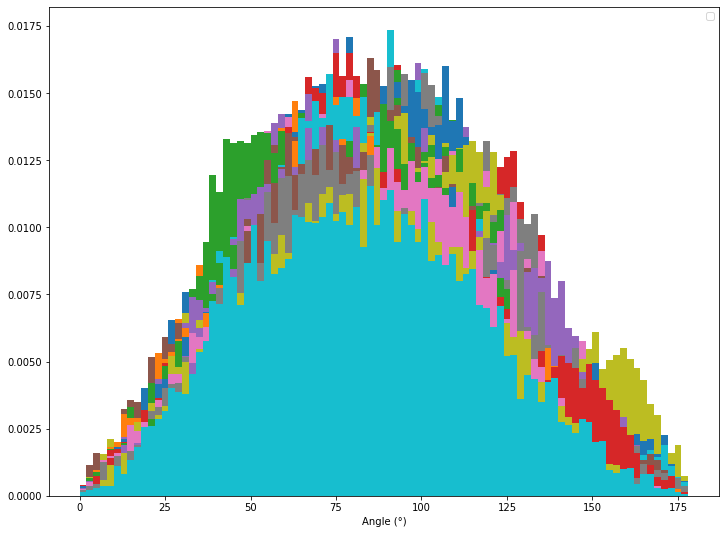

In [30]:
#Calculate the angle between PN vector and z-axis for each lipid residues

lipids = {'POPS','POPE','POPG','POPC'}
#lipids = {'POPE'}
atom1 = 'M_G3P2_M'
atom2 = 'M_G3C5O1_M'   #for POPG
#atom2 = 'M_G3N6_M'

colors = {'POPC' :'black','POPS':'red','POPE':'blue','POPG':'green'}

h = []


for subdir, dirs, files in os.walk(r'../Data/Simulations/'):
    for filename in files:
        filepath = subdir + os.sep + filename
        if filepath.endswith("README.yaml"):
            READMEfilepath = subdir + '/README.yaml'
            with open(READMEfilepath) as yaml_file:
                readme = yaml.load(yaml_file, Loader=yaml.FullLoader)
                for molname in lipids:
                    doi = readme.get('DOI')
                    trj = readme.get('TRJ')
                    tpr = readme.get('TPR')
                    trj_name = subdir + '/' + readme.get('TRJ')[0][0]
                    tpr_name = subdir + '/' + readme.get('TPR')[0][0]
                    gro_name = subdir + '/conf.gro'
                    trj_url = download_link(doi, trj[0][0])
                    tpr_url = download_link(doi, tpr[0][0])
                    EQtime=float(readme.get('TIMELEFTOUT'))*1000

                    HGorientationFOLDERS = subdir.replace("Simulations","HGorientation")    
                    outfilename = str(HGorientationFOLDERS) + '/' + molname + 'PNvectorDIST.dat' 
                                   
                    if not os.path.isfile(outfilename) and sum(readme['N' + molname]) > 0:
                                            
                        print('Analyzing '+molname+' in '+filepath)
                        
                        #Download tpr and xtc files to same directory where dictionary and data are located
                        if (not os.path.isfile(tpr_name)):
                            response = urllib.request.urlretrieve(tpr_url, tpr_name)
                        
                        if (not os.path.isfile(trj_name)):
                            response = urllib.request.urlretrieve(trj_url, trj_name)
                        
                        fig= plt.figure(figsize=(12,9))
                        if (not os.path.isfile(gro_name)):
                            !echo System | gmx trjconv -f {trj_name} -s {tpr_name}  -dump 0 -o {gro_name}
                        
                        xtcwhole=subdir + '/whole.xtc'
                        if (not os.path.isfile(xtcwhole)):
                            !echo System | gmx trjconv -f {trj_name} -s {tpr_name} -o {xtcwhole} -pbc mol -b {EQtime}
                        
                        mapping_file = './mapping_files/'+readme['MAPPING_DICT'][molname] # readme.get('MAPPING')[0][0]
                                                
                        try:
                            atoms = read_mapping_filePAIR(mapping_file, atom1 , atom2)
                        except:
                            print(atom1 + " and " + atom2 + " not found in the mapping file.")
                            continue

                        
                        try:
                            anglesMeanError = read_trj_PN_angles(molname, atoms, tpr_name, xtcwhole, gro_name)
                        except OSError:
                            print("Could not calculate angles for " + molname + " from files " + tpr_name + " and " + trj_name)
                            continue
                        angles = anglesMeanError[0]
                        resAverageAngles = anglesMeanError[1]
                        totalAverage = anglesMeanError[2]
                        totalAverageError = anglesMeanError[3]
                        
                        #print(resAverageAngles)
                        
                        #fig= plt.figure(figsize=(12,9))
                        print(len(angles))
                        dist = [ 0 for i in range(len(angles))]
                        distSUM = [ 0 for i in range(0,178,2)]
                        # print(distSUM)
                        for i in range(len(angles)):
                            dist[i] = plt.hist(angles[i], bins=range(0,180,2), density=True)
                            distSUM = np.add(distSUM,dist[i][0])
                            #print(np.sum(dist[i][0]))
                            #print(np.sum(distSUM))
                            
                        # print(distSUM)
                        distSUM = [x / len(angles) for x in distSUM]
                        print(np.sum(distSUM))
                        
                        #print(len(dist))
                        xaxis = [ 0 for i in range(len(dist[0][1])-1)]
                        for i in range(len(dist[0][1])-1):
                            xaxis[i]=(dist[0][1][i])
                        
                        plt.legend()
                        plt.xlabel("Angle (°)")
                        #print(molname)
                        #print(colors[molname])
                        
                        
                        !mkdir -p {HGorientationFOLDERS}
                        !cp {READMEfilepath} {HGorientationFOLDERS}
                        outfile=open(outfilename,'w')
                        
                        for i in range(len(xaxis)):
                            #print(xaxis[i],distSUM[i])
                            outfile.write(str(xaxis[i]) + " " + str(distSUM[i])+'\n')
                        outfile.close()
                        outfile=open(str(HGorientationFOLDERS) + '/' + molname + 'PNvectorAVERAGE.dat','w')
                        outfile.write(str(totalAverage) + " " + str(totalAverageError)+'\n')
                        outfile.close()
            
#labels = [l.get_label() for l in h]
#plt.legend(h, labels, loc='best',ncol=2)
#plt.xlabel("Angle (°)")

In [45]:
print(totalAverage,totalAverageError)

62.26868159127615 6.532079654694839


In [31]:
colors = {'POPC' :'black','POPS':'red','POPE':'blue','POPG':'green'}
markers = {'POPC' :'s','POPS':'o','POPE':'o','POPG':'s'}
lipids = ['POPC','POPS','POPE','POPG']
#DOIs = {'POPC' :'10.5281/zenodo.3474862','POPG' :'10.5281/zenodo.1011096','POPS' :'10.5281/zenodo.1129415','POPE' :'10.5281/zenodo.2641987'}

PNangles = {}
resultsPOPG = {}

!rm ../Data/PNanglePOPCvsPOPEcharmmT300K.dat 
!rm ../Data/PNanglePOPCvsPOPEslipidsT300K.dat 
!rm ../Data/PNanglePOPCvsPOPEmacrogT300K.dat
!rm ../Data/PNanglePOPCvsPOPGslipidT310K.dat
!rm ../Data/PNanglePOPCvsPOPGslipidT298K.dat
!rm ../Data/PNanglePOPCvsPOPGcharmmT310K.dat
!rm ../Data/PNanglePOPCvsPOPGslipidWITHCaCl.dat
!rm ../Data/PNanglePOPGslipidWITHCaCl.dat
!rm ../Data/PNanglePCPOPCPOPG1:1charmmWITHCaCl.dat
!rm ../Data/PNanglePGPOPCPOPG1:1charmmWITHCaCl.dat
!rm ../Data/PNanglePOPGvsPOPCcharmmT310K.dat
    
fig= plt.figure(figsize=(10,7))
for subdir, dirs, files in os.walk(r'../Data/HGorientation/'):
    for filename in files:
        filepath = subdir + os.sep + filename
        if filepath.endswith("README.yaml"):
            READMEfilepath = subdir + '/README.yaml'
            with open(READMEfilepath) as yaml_file:
                readme = yaml.load(yaml_file, Loader=yaml.FullLoader)
                Nlipids = [readme.get('N' + lipids[0])[0],readme.get('N' + lipids[1])[0],readme.get('N' + lipids[2])[0],readme.get('N' + lipids[3])[0]]
                PNfilepath = subdir + '/' + lipids[0] + 'PNvectorAVERAGE.dat'
                PNfilepathPOPG = subdir + '/' + lipids[3] + 'PNvectorAVERAGE.dat'
                #print(readme)
                PNangle = !cat {PNfilepath}
                PNanglePOPG = !cat {PNfilepathPOPG}
                if('10.5281/zenodo.1306800' in readme.get('DOI') or '10.5281/zenodo.1306821' in readme.get('DOI')):
                    outfile1=open('../Data/PNanglePOPCvsPOPEcharmmT300K.dat','a')
                    PEratio = Nlipids[2]/(Nlipids[2]+Nlipids[0])
                    outfile1.write(str(PEratio) + '  ' + str(PNangle[0]) + '\n')
                    outfile1.close()
                    #!sort ../Data/PNanglePOPCvsPOPEslipidsT300K.dat -o ../Data/PNanglePOPCvsPOPEslipidsT300K.dat
                if('10.5281/zenodo.166034' in readme.get('DOI') or '10.5281/zenodo.3605386' in readme.get('DOI')):
                    outfile1=open('../Data/PNanglePOPCvsPOPEslipidsT300K.dat','a')
                    PEratio = Nlipids[2]/(Nlipids[2]+Nlipids[0])
                    outfile1.write(str(PEratio) + '  ' + str(PNangle[0]) + '\n')
                    outfile1.close()
                if('10.5281/zenodo.3741793' in readme.get('DOI') or '10.5281/zenodo.3725637' in readme.get('DOI')):
                    outfile1=open('../Data/PNanglePOPCvsPOPEmacrogT300K.dat','a')
                    PEratio = Nlipids[2]/(Nlipids[2]+Nlipids[0])
                    outfile1.write(str(PEratio) + '  ' + str(PNangle[0]) + '\n')
                    outfile1.close()
                if('10.5281/zenodo.3247813' in readme.get('DOI') or '10.5281/zenodo.3248689' in readme.get('DOI')):
                    outfile1=open('../Data/PNanglePOPCvsPOPGcharmmT310K.dat','a')
                    PEratio = Nlipids[3]/(Nlipids[3]+Nlipids[0])
                    outfile1.write(str(PEratio) + '  ' + str(PNangle[0]) + '\n')
                    outfile1.close()
                if('10.5281/zenodo.3237463' in readme.get('DOI') or '10.5281/zenodo.3248689' in readme.get('DOI')):
                    outfile1=open('../Data/PNanglePOPGvsPOPCcharmmT310K.dat','a')
                    PEratio = Nlipids[3]/(Nlipids[3]+Nlipids[0])
                    outfile1.write(str(PEratio) + '  ' + str(PNanglePOPG[0]) + '\n')
                    outfile1.close()
                if('10.5281/zenodo.3235552' in readme.get('DOI') or '10.5281/zenodo.3240156' in readme.get('DOI')):
                    outfile1=open('../Data/PNanglePOPCvsPOPGslipidT310K.dat','a')
                    PEratio = Nlipids[3]/(Nlipids[3]+Nlipids[0])
                    outfile1.write(str(PEratio) + '  ' + str(PNangle[0]) + '\n')
                    outfile1.close()
                if('10.5281/zenodo.166034' in readme.get('DOI') or '10.5281/zenodo.3613573' in readme.get('DOI') and readme.get('NCAL') < 1):
                    outfile1=open('../Data/PNanglePOPCvsPOPGslipidT298K.dat','a')
                    PEratio = Nlipids[3]/(Nlipids[3]+Nlipids[0])
                    outfile1.write(str(PEratio) + '  ' + str(PNangle[0]) + '\n')
                    outfile1.close()
                if('10.5281/zenodo.3613573' in readme.get('DOI')):
                    outfile1=open('../Data/PNanglePOPCvsPOPGslipidWITHCaCl.dat','a')
                    PEratio = Nlipids[3]/(Nlipids[3]+Nlipids[0])
                    CaConcentration = readme.get('NCAL') * 55.5 / readme.get('NSOL')
                    outfile1.write(str(PEratio) + '  ' + str(PNangle[0]) + ' ' + str(readme.get('TRJ')) + '\n')
                    outfile1.close()
                    outfile1=open('../Data/PNanglePOPGslipidWITHCaCl.dat','a')
                    outfile1.write(str(PEratio) + '  ' + str(PNanglePOPG[0]) + ' ' + str(readme.get('TRJ')) + '\n')
                    outfile1.close()
                if('10.5281/zenodo.3997116' in readme.get('DOI') or '10.5281/zenodo.3997135' in readme.get('DOI')):
                    outfile1=open('../Data/PNanglePCPOPCPOPG1:1charmmWITHCaCl.dat','a')
                    PEratio = Nlipids[3]/(Nlipids[3]+Nlipids[0])
                    CaConcentration = readme.get('NCAL') * 55.5 / readme.get('NSOL')
                    outfile1.write(str(PEratio) + '  ' + str(PNangle[0]) + ' ' + str(readme.get('SYSTEM')) + '\n')
                    outfile1.close()
                    outfile1=open('../Data/PNanglePGPOPCPOPG1:1charmmWITHCaCl.dat','a')
                    outfile1.write(str(PEratio) + '  ' + str(PNanglePOPG[0]) + ' ' + str(readme.get('SYSTEM')) + '\n')
                    outfile1.close()
                    
                #PNangles[readme] = PNangle 
                #print(PNangle[0])
                #if(Nlipids[0] > 0):
                    #outfile1=open('../Data/' + str(Nlipids[0]) 'vs' + str(Nlipids[1]) + 'T' + str(readme.get('TEMPERATURE')) + 'PNvector.dat','a')
                    #outfile1=open('../Data/' + str(Nlipids[0]) 'vs' + str(Nlipids[1]) + 'T' + str(readme.get('TEMPERATURE')) + 'PNvector.dat','a')
                    #outfile1=open('../Data/' + str(Nlipids[0]) 'vs' + str(Nlipids[1]) + 'T' + str(readme.get('TEMPERATURE')) + 'PNvector.dat','a')
                #print(Nlipids)
                #if Nlipids[0] > 0 and Nlipids[1] > 0:
                #    CaConcentration = readme.get('NCAL') * 55.5 / readme.get('NSOL')
                #    lipidsRATIO = 100* Nlipids[1] / (Nlipids[0] + Nlipids[1])
                #    forcefield = readme.get('FF')
                #    OPfilepath = subdir + '/POPCOrderParameters.json'
                #    OPfilepathPOPG = subdir + '/POPGOrderParameters.json'
                #    try :
                #        with open(OPfilepath) as json_file:
                #            data = json.load(json_file)
                #            results[lipidsRATIO,CaConcentration,forcefield] = data
                #    except :
                #        print('Order parameter file not found')
                #    try :
                #        with open(OPfilepathPOPG) as json_file:
                #            data = json.load(json_file)
                #            resultsPOPG[lipidsRATIO,CaConcentration,forcefield] = data
                #    except :
                #        print('Order parameter file not found')
                    #print(data)
                    #BetaANDalphaOPs = [data['M_G3C5_M M_G3C5H1_M'],data['M_G3C5_M M_G3C5H2_M'],data['M_G3C4_M M_G3C4H1_M'],data['M_G3C4_M M_G3C4H2_M']]
                    
                    #print(readme.get('NPOPC')[0], readme.get('NPOPG')[0], readme.get('NCAL'))
                    #print(readme)


rm: cannot remove '../Data/PNanglePOPGvsPOPCcharmmT310K.dat': No such file or directory


<Figure size 720x504 with 0 Axes>